# Getting started with Task 3

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) using the script `download_intracardiac_dataset.sh`:

```bash
source download_intracardiac_dataset.sh
```

## Load Modules and Preprocessing Functions

Load modules and preprocessing functions.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive_path = '/content/drive/MyDrive/cardiac_challenge_team6'
local_path = '../'

In [3]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

Load the `cardiac_ml_tools` module.

In [ ]:
%run $drive_path/notebooks/cardiac_ml_tools.py

## Load the dataset

In [ ]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR= '../intracardiac_dataset/'  # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))


## Dataset details

The dataset [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106)
consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals.
In total, 16140 organ-level simulations were conducted to create this dataset.
Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores.
Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals.
For convenience, we collect those signals in matrices and give them the following names:

Tensor | Description | Shape | Notes
--- | --- | --- | ---
$X$ | Row electrode signals | $10 \times 500$ | 10-lead ECG signals from the simulated torso (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$V$ | Activation map | $75 \times 500$ | Transmembrane voltage signals from the simulated heart (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$E$ | 12-lead ECG signals | $12 \times 500$ | 12-lead ECG signals obtained by `get_standard_leads`($X$)
$A$ | Activation map | $75 \times 1$ | Activation time, defined as $A_i = \text{min}_j(V_{ij})$

**IMPORTANT** : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function `get_standard_leads` (in the file `cardiac_ml_tools.py`).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

![ECG 10 2 12](../figures/data_generation.png)

## Getting the standard 12-lead ECG from the 10-lead ECG

The function `get_standard_leads` (in the file `cardiac_ml_tools.py`) is used to obtain the 12-lead ECG signals from the 10-lead ECG signals. It implements the following transformation, where the (Wilson Lead) is defined as $Vw = 1/3*(RA + LA + LL)$:
$$
\left\{
\begin{array}{lll}
    X_{:,1}  & \to  & RA \\
    X_{:,2}  & \to  & LA \\
    X_{:,3}  & \to  & LL \\
    X_{:,4}  & \to  & RL \\
    X_{:,5}  & \to  & V1 \\
    X_{:,6}  & \to  & V2 \\
    X_{:,7}  & \to  & V3 \\
    X_{:,8}  & \to  & V4 \\
    X_{:,9}  & \to  & V5 \\
    X_{:,10} & \to &  V6 \\
\end{array}
\right.
\text{        and        }
\left\{
\begin{array}{lll}          
\text{Lead } I& : & LA - RA \\
\text{Lead } II& : & LL - RA \\
\text{Lead } III& : & LL - LA \\
\text{Lead } aVR& : &  \frac{3}{2} (RA - Vw) \\
\text{Lead } aVL& : &  \frac{3}{2} (LA - Vw) \\
\text{Lead } aVF& : &  \frac{3}{2} (LL - Vw)\\
\text{Lead } V1 & : & V1 - Vw \\
\text{Lead } V2 & : & V2 - Vw \\
\text{Lead } V3 & : & V3 - Vw \\
\text{Lead } V4 & : & V4 - Vw \\
\text{Lead } V5 & : & V5 - Vw \\
\text{Lead } V6 & : & V6 - Vw \\
\end{array}
\right.
$$


In [ ]:
# Example of file pair
case = 213
# ECG plot
row = 3
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

## Getting the transmembrane voltages

In [ ]:
# Example of file pair
case = 213
# Vm plot
row = 7
column = 10
plt.figure(figsize=(18, 9))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()


## Task 4: Learning the mapping from the 12-lead ECG to the 75 transmembrane voltages

In [ ]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print a text "->"
plt.text(0.5, 0.5, '-------->', fontsize=40, horizontalalignment='center', verticalalignment='center')
plt.axis('off')
plt.subplot(row, column, 3)
# plot Vm transposed
plt.imshow(VmData.T, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('VmData')
plt.show()
plt.close()

# Tricks

- As in many machine learning problems, normalization of the data might be helpful or even necessary. Different normalization schemes might be applied.

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, BatchNormalization, MaxPooling1D,\
UpSampling1D, Conv1DTranspose, Concatenate, Input, Cropping1D, ZeroPadding1D
from tensorflow.keras import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [5]:
# load data from files into numpy arrays

ECG_Data = np.load(f'{drive_path}/Task_3_4_Data/ECG_Data.npy')
ActTimes = np.load(f'{drive_path}/Task_3_4_Data/Activation_Times.npy')
VMData = np.load(f'{drive_path}/Task_3_4_Data/VmData.npy')

In [6]:
# load norm data
ecg_data_norm = np.load(f'{drive_path}/Task_3_4_Data_norm/ECG_Data_NORM.npy')
vm_data_norm = np.load(f'{drive_path}/Task_3_4_Data_norm/VmData_NORM.npy')
act_data_norm = np.load(f'{drive_path}/Task_3_4_Data_norm/Activation_Times_NORM.npy')

In [7]:
# split data
# 80% test data, 15% validation, 5% test

x_train, x_temp, y_train, y_temp = train_test_split(
    ecg_data_norm, vm_data_norm, test_size=.17, random_state=24
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=.08, random_state=24
)

print(x_train.shape, y_train.shape)

(13377, 500, 12) (13377, 500, 75)


In [8]:
def R2(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.truediv(residual, total))
  return r2

In [18]:
''' Model C
R2 @ 200 epochs = 0.9###

Params:

Model implemented using conv and deconv layers with skip connections
(same as Model B but with 1 extra conv and upsample block)
'''

in_shape = (500,12)

# input layer
inputs = Input(shape=in_shape)

# conv block 1
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling1D(pool_size=2)(conv1)

# conv block 2
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling1D(pool_size=2)(conv2)

# conv block 3
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool2)
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(conv3)
pool3 = MaxPooling1D(pool_size=2)(conv3)

# conv block 4
conv4 = Conv1D(filters=512, kernel_size=3, activation='relu', padding='same')(pool3)
conv4 = Conv1D(filters=512, kernel_size=3, activation='relu', padding='same')(conv4)

# upsample block 1
up1 = UpSampling1D(size=2)(conv4)
conv3 = Conv1D(filters=256, kernel_size=2, activation='relu')(conv3) # resize
merge1 = Concatenate()([up1, conv3])
conv5 = Conv1D(filters=256, kernel_size=6, activation='relu', padding='same')(merge1)
conv5 = Conv1D(filters=256, kernel_size=6, activation='relu', padding='same')(conv5)

# upsample block 2
up2 = UpSampling1D(size=2)(conv5)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(conv2) # resize
merge2 = Concatenate()([up2, conv2])
conv6 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(merge2)
conv6 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv6)

# upsample block 3
up3 = UpSampling1D(size=2)(conv6)
conv1 = Conv1D(filters=64, kernel_size=5, activation='relu')(conv1) # resize
merge3 = Concatenate()([up3, conv1])
conv7 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(merge3)
conv7= Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv7)

# expand dim from 496 -> 500
outputs = ZeroPadding1D(padding=(2,2))(conv7)

# fc layer
outputs = Dense(units=75, activation='tanh')(outputs)


sample_batch = tf.zeros((1,) + in_shape)
sc_model = Model(inputs=inputs, outputs=outputs)
print(sc_model.summary())


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 500, 12)]    0           []                               
                                                                                                  
 conv1d_71 (Conv1D)             (None, 500, 64)      2368        ['input_6[0][0]']                
                                                                                                  
 conv1d_72 (Conv1D)             (None, 500, 64)      12352       ['conv1d_71[0][0]']              
                                                                                                  
 max_pooling1d_13 (MaxPooling1D  (None, 250, 64)     0           ['conv1d_72[0][0]']              
 )                                                                                          

In [19]:
# fit model

sc_model.compile(optimizer='adam', loss='mse', metrics=[R2])
hist = sc_model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    epochs=240,
    batch_size=64,
    verbose=1
)

Epoch 1/240
210/210 [==============================] - 27s 86ms/step - loss: 0.0475 - R2: 0.5867 - val_loss: 0.0195 - val_R2: 0.8297
Epoch 2/240
210/210 [==============================] - 16s 78ms/step - loss: 0.0161 - R2: 0.8592 - val_loss: 0.0155 - val_R2: 0.8638
Epoch 3/240
210/210 [==============================] - 17s 79ms/step - loss: 0.0146 - R2: 0.8726 - val_loss: 0.0145 - val_R2: 0.8730
Epoch 4/240
210/210 [==============================] - 16s 77ms/step - loss: 0.0213 - R2: 0.8140 - val_loss: 0.0190 - val_R2: 0.8333
Epoch 5/240
210/210 [==============================] - 16s 76ms/step - loss: 0.0152 - R2: 0.8670 - val_loss: 0.0163 - val_R2: 0.8568
Epoch 6/240
210/210 [==============================] - 16s 76ms/step - loss: 0.0143 - R2: 0.8749 - val_loss: 0.0151 - val_R2: 0.8680
Epoch 7/240
210/210 [==============================] - 16s 76ms/step - loss: 0.0138 - R2: 0.8791 - val_loss: 0.0143 - val_R2: 0.8751
Epoch 8/240
210/210 [==============================] - 16s 76ms/step 

In [14]:
sc_model.save(f'{drive_path}/trained_models/task_4_mapping_skip_connections_3_blocks_R2.9664.h5')

with open(f'{drive_path}/trained_models/task_4_mapping_skip_connections_3_blocks_R2.9664.pkl', 'wb') as file:
  pickle.dump(hist.history, file)

'''

convnet_model.save(f'{drive_path}/trained_models/task_4_mapping_convnet_R2.9###.h5')

with open(f'{drive_path}/trained_models/task_4_mapping_convnet_R2.9###.pkl', 'wb') as file:
  pickle.dump(hist.history, file)'''

"\n\nconvnet_model.save(f'{drive_path}/trained_models/task_4_mapping_convnet_R2.9###.h5')\n\nwith open(f'{drive_path}/trained_models/task_4_mapping_convnet_R2.9###.pkl', 'wb') as file:\n  pickle.dump(hist.history, file)"

In [11]:
# Load model previously saved

tf.keras.utils.get_custom_objects().update({'R2': R2})

#model = tf.keras.models.load_model(f'{drive_path}/trained_models/task_4_mapping_convnet_R2.h5') # convnet_model
model = tf.keras.models.load_model(f'{drive_path}/trained_models/task_4_mapping_skip_connections_3_blocks_R2.9664.h5') # sc_model
with open(f'{drive_path}/trained_models/task_4_mapping_skip_connections_3_blocks_R2.9664.pkl', 'rb') as file:
  hist = pickle.load(file)

print(hist)


{'loss': [0.046301715075969696, 0.01821020245552063, 0.015340137295424938, 0.014436137862503529, 0.013898324221372604, 0.018185576424002647, 0.013456222601234913, 0.01296100951731205, 0.01258918084204197, 0.012317345477640629, 0.012009691447019577, 0.013243465684354305, 0.011588887311518192, 0.011329928413033485, 0.011070876382291317, 0.010701329447329044, 0.010723330080509186, 0.010279863141477108, 0.010149314068257809, 0.015163369476795197, 0.011756294406950474, 0.010890069417655468, 0.010124551132321358, 0.0099667152389884, 0.00949184037744999, 0.009469151496887207, 0.009106327779591084, 0.00910920649766922, 0.008904929272830486, 0.009110729210078716, 0.008758820593357086, 0.008841807022690773, 0.00837327353656292, 0.008225400000810623, 0.014615003019571304, 0.01102985069155693, 0.009417232125997543, 0.008790535852313042, 0.008574722334742546, 0.008459817618131638, 0.008378922939300537, 0.007976065389811993, 0.00770745100453496, 0.007648391183465719, 0.007482439745217562, 0.00746086

In [10]:
# if not using previously saved model...

model = sc_model
#model = convnet_model

NameError: ignored

In [12]:
def vm_unnorm(norm_vm, min_vm, max_vm):
  vm_unnorm = np.zeros((norm_vm.shape[0], norm_vm.shape[1], norm_vm.shape[2]))

  for i, heart in enumerate(norm_vm):
    for j, mapping in enumerate(heart):
      for k, scaled_voltage in enumerate(mapping):
        temp_min = min_vm[k]
        temp_max = max_vm[k]
        original = scaled_voltage * (temp_max - temp_min) + temp_min
        vm_unnorm[i][j][k] = original
  return vm_unnorm

min_vm = np.amin(VMData, axis=(0,1))
max_vm = np.amax(VMData, axis=(0,1))

y_test_unnorm = vm_unnorm(y_test, min_vm, max_vm)

In [13]:
y_pred = model.predict(x_test)


7/7 [==============================] - 9s 55ms/step


In [14]:
print(y_test.shape, y_pred.shape, x_test.shape)
y_pred_unnorm = vm_unnorm(y_pred, min_vm, max_vm)
print(y_test_unnorm.shape, y_pred_unnorm.shape)
diff =  abs( y_pred_unnorm - y_test_unnorm )
print(np.mean(diff))

(220, 500, 75) (220, 500, 75) (220, 500, 12)
(220, 500, 75) (220, 500, 75)
5.276177852659159


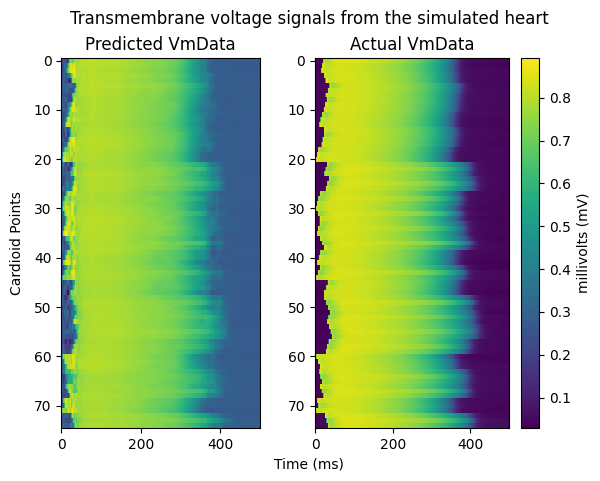

In [27]:
# plot mapping
# y axis cardioid points, x axis time, colormap mV
# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
heart=218
fig,axes = plt.subplots(1, 2, gridspec_kw={'width_ratios':[0.82,1]})

big_ax = fig.add_subplot(111,zorder=-1) # disable axis lines and ticks for 'big' subplot
big_ax.spines['top'].set_color('none')
big_ax.spines['bottom'].set_color('none')
big_ax.spines['left'].set_color('none')
big_ax.spines['right'].set_color('none')
big_ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
big_ax.set_ylabel('Cardioid Points')
big_ax.set_xlabel('Time (ms)')
big_ax.set_title('Transmembrane voltage signals from the simulated heart', y=1.07)

axes[0].imshow(y_pred[heart].T, cmap='viridis', interpolation='nearest', aspect='auto')
axes[0].set_title("Predicted VmData")

im = axes[1].imshow(y_test[heart].T, cmap='viridis', interpolation='nearest', aspect='auto')
axes[1].set_title('Actual VmData')
cbar = fig.colorbar(im)
cbar.set_label('millivolts (mV)')
plt.subplots_adjust(wspace=0.25)
plt.savefig(f'{drive_path}/data_visualization/task4_vm_actual_vs_pred.png', dpi=800, transparent=True)
plt.show()

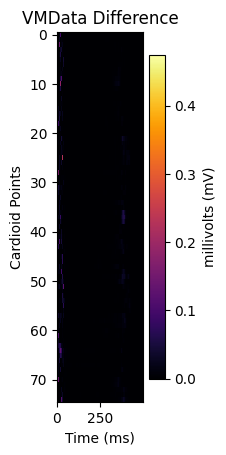

In [29]:
# plot mapping difference
heart = 218
plt.figure(1)
plt.subplot(1,3,2)
# plot Vm transposed
difference = np.square(y_pred[heart].T - y_test[heart].T)
im = plt.imshow(difference, cmap='inferno', interpolation='nearest', aspect='auto')
plt.title('VMData Difference')
cbar = plt.colorbar(im)
cbar.set_label('millivolts (mV)')
plt.ylabel('Cardioid Points')
plt.xlabel('Time (ms)')

plt.subplots_adjust(wspace=0.8)
plt.savefig(f'{drive_path}/data_visualization/task4_vm_difference.png', dpi=800, transparent=True)
plt.show()

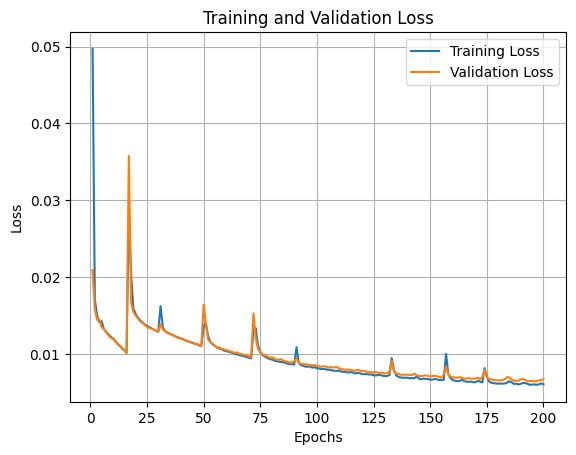

In [ ]:
# Get the training and validation loss values from the history
train_loss = hist['loss']
val_loss = hist['val_loss']

# Create a plot to visualize the loss values
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [32]:
# Get the training and validation R2 values from the history
R2 = hist['R2']
val_R2 = hist['val_R2']

# Create a plot to visualize R2 over epochs
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, R2, label='Training R2')
plt.plot(epochs, val_R2, label='Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.title('Training and Validation R2-score')
plt.legend()
plt.grid()
plt.show()

NameError: ignored

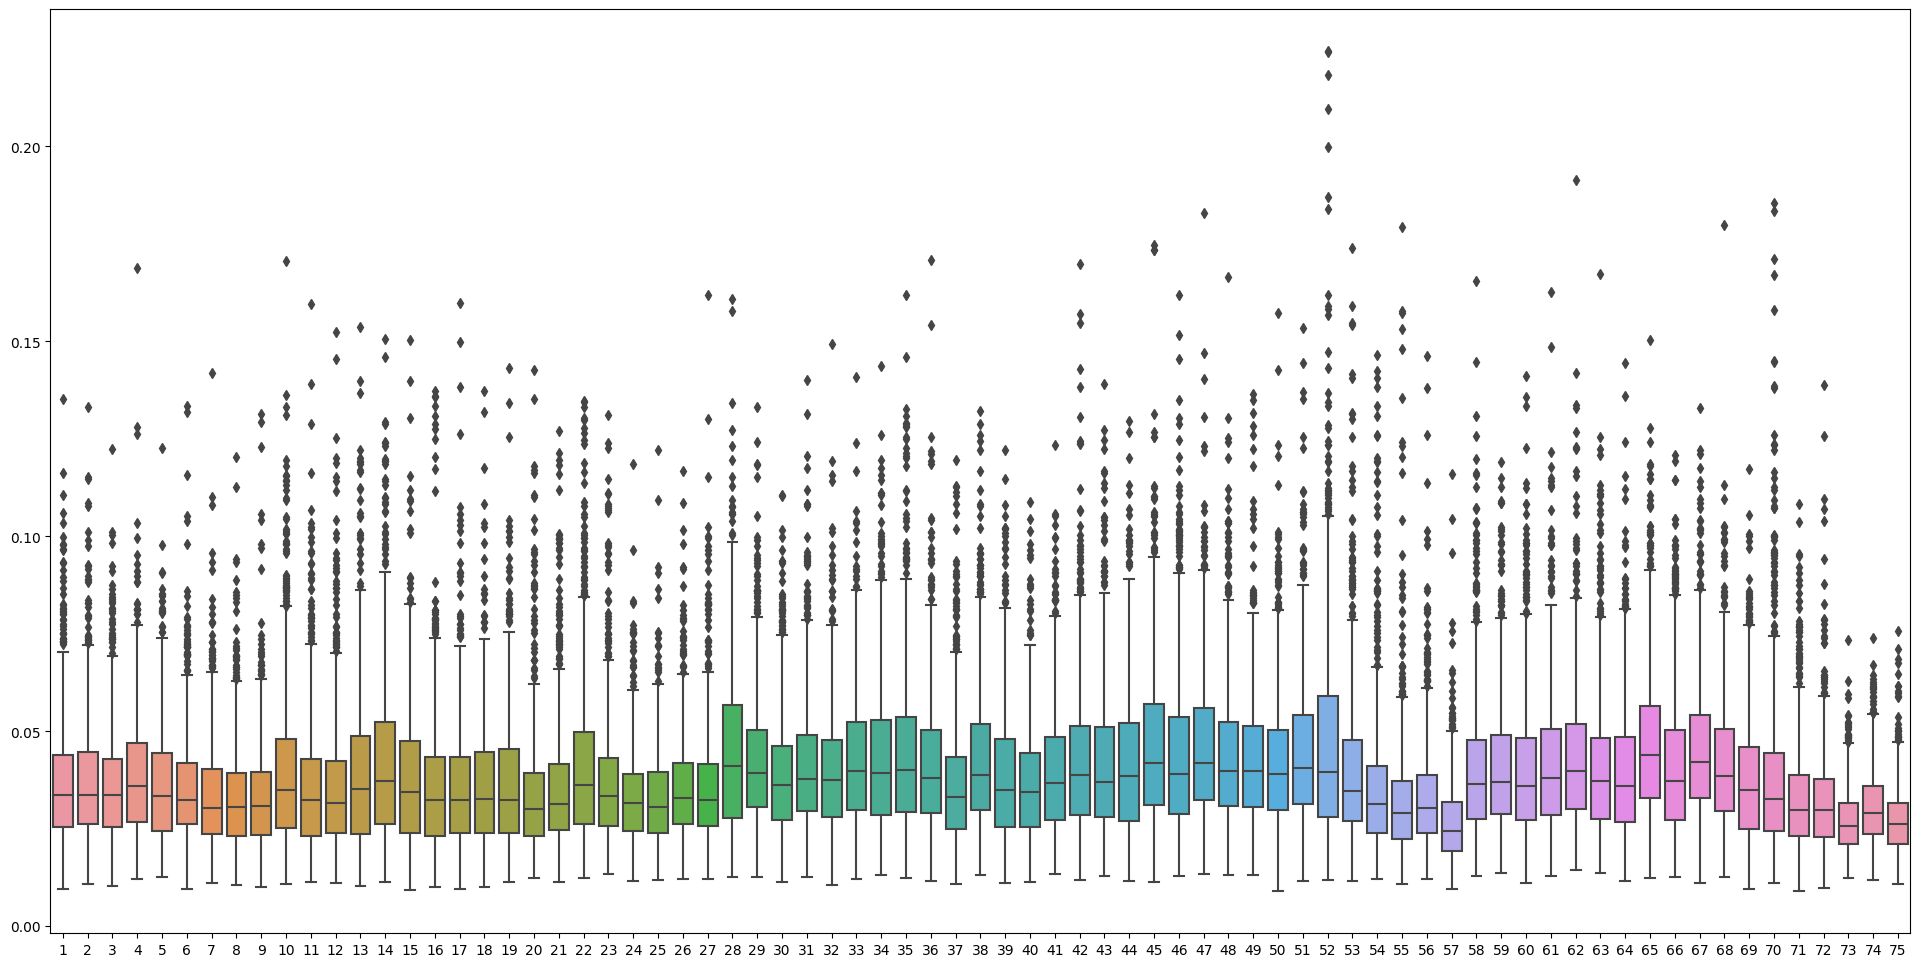

In [56]:
def box_plots(predictions, y_values):
  import seaborn as sns
  import pandas as pd

  transposed_preds = np.transpose(predictions, (0, 2, 1))
  transposed_Y = np.transpose(y_values, (0, 2, 1))

  transposed_diff = abs(transposed_Y - transposed_preds)

  df = pd.DataFrame([], range(transposed_preds.shape[0]) ,range(1, transposed_preds.shape[1]+1))

  for sample in range(transposed_diff.shape[0]):
    for point in range(1, transposed_diff.shape[1]+1):
      df[(point)][sample] = transposed_diff[sample][point-1].mean()

  plt.figure(figsize=(24,12))
  sns.boxplot(data=df, orient = 'v')

box_plots(y_pred, y_test)

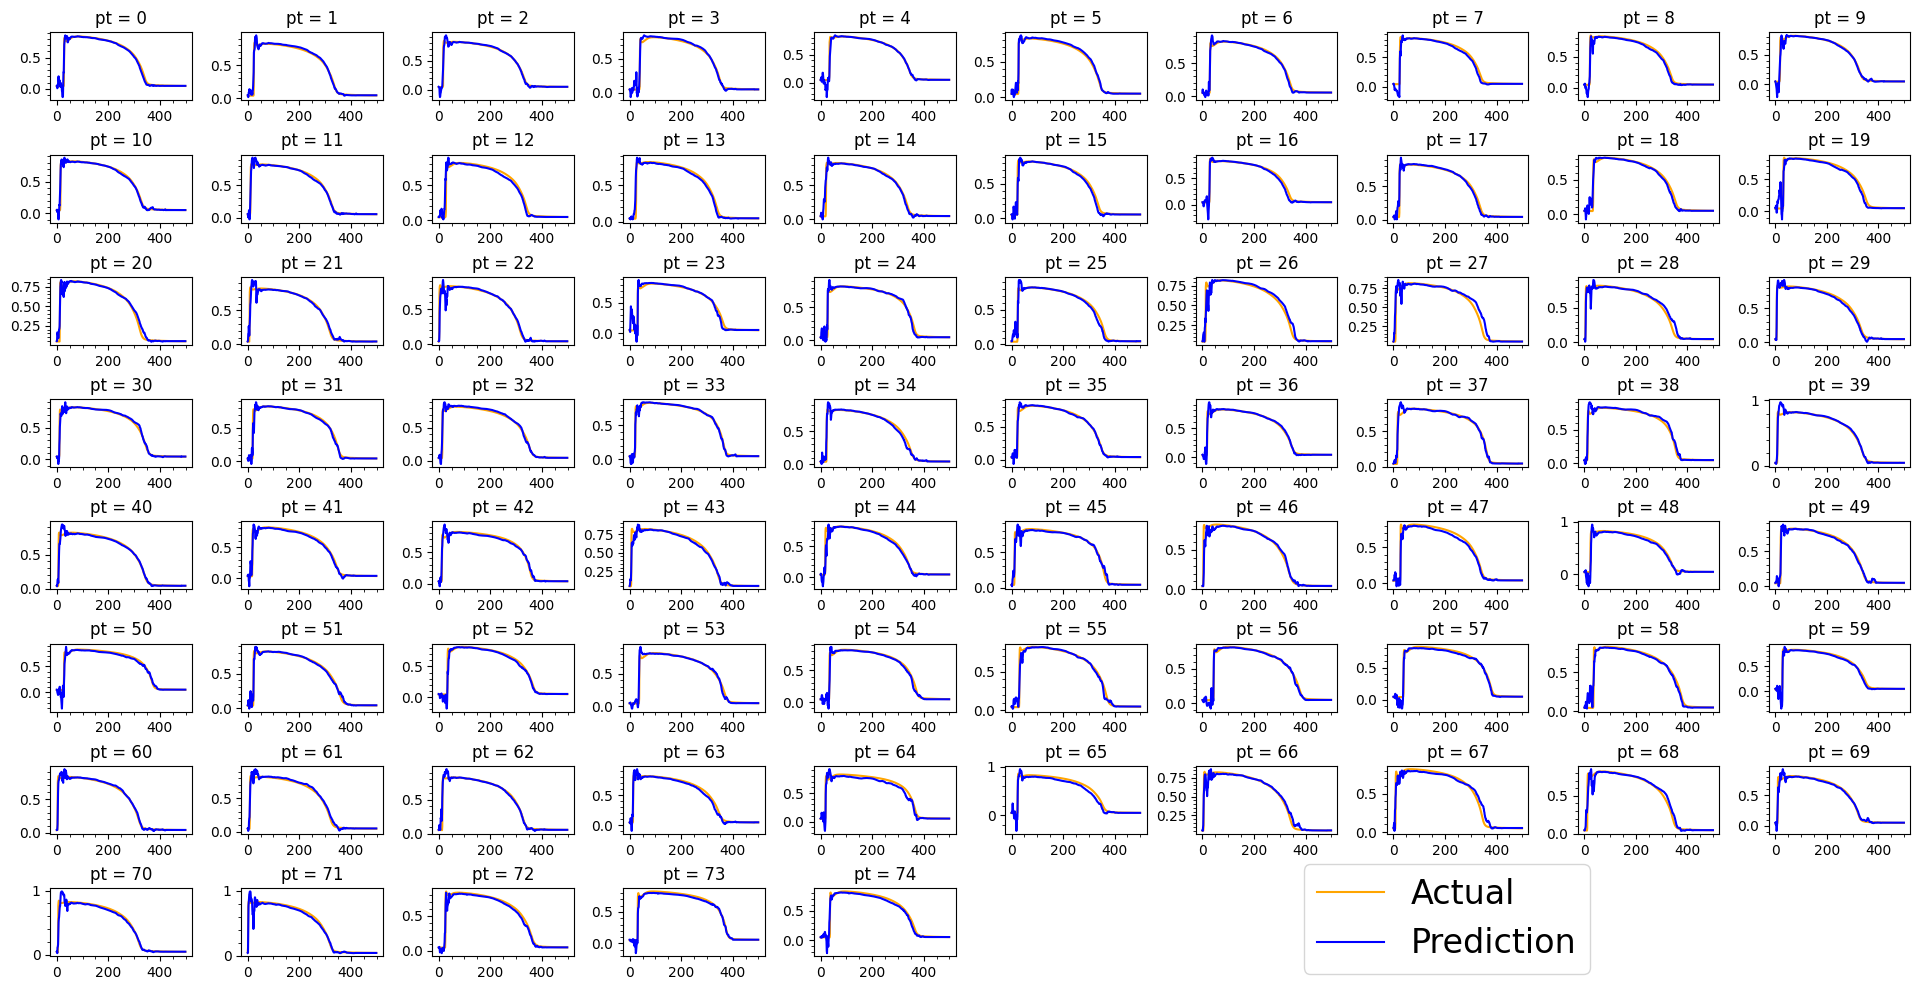

In [31]:
# graph VmData for a single sample (given in the getting started notebook)

def VmGraph(VmData_pred, VmData_actual):
  plt.figure(figsize=(24, 12))
  num_timesteps = 500

  for count, i in enumerate(range(VmData_pred.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData_actual[0:num_timesteps,i], color='orange', label='Actual')
    plt.plot(VmData_pred[0:num_timesteps,i], color='blue', label='Prediction')
    plt.title(f'pt = {i}')
    #plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    #plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
  plt.legend(loc='lower right', bbox_to_anchor=(5.6,-0.5), fontsize='24')
  plt.subplots_adjust(wspace=0.35,hspace=0.8)
  #plt.tight_layout()

  plt.savefig(f'{drive_path}/data_visualization/task4_vm_75_cardioid_graphs.png', dpi=1000, transparent=True)
  plt.show()

VmGraph(y_pred[100], y_test[100])

In [ ]:
''' Model A
R2 @ 200 epochs = 0.9###

Params: 3.84M

Implemented with several convolution layers and pooling layers,
with transpose convolution layers to re exapnd the size after pooling
'''

# output_shape = ((input_shape - kernel_size) / stride) + 1
convnet_model = Sequential()

convnet_model.add(Conv1D(filters=75, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(500,12)))
convnet_model.add(Conv1D(filters=64, kernel_size=6, strides=3, padding='same', activation='relu'))
convnet_model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
convnet_model.add(MaxPooling1D(pool_size=2))
convnet_model.add(BatchNormalization())

convnet_model.add(Conv1DTranspose(filters=64, kernel_size=3, strides=2, activation='relu'))
convnet_model.add(Conv1DTranspose(filters=128, kernel_size=12, strides=4, activation='relu'))
convnet_model.add(Conv1D(filters=128, kernel_size=9, strides=1, activation='relu'))
convnet_model.add(Conv1D(filters=256, kernel_size=12, strides=1, activation='relu'))
convnet_model.add(BatchNormalization())

convnet_model.add(Conv1DTranspose(filters=256, kernel_size=12, strides=3, activation='relu'))
convnet_model.add(Conv1D(filters=512, kernel_size=24, strides=1, activation='relu'))
convnet_model.add(Conv1D(filters=64, kernel_size=6, strides=1, activation='relu'))
convnet_model.add(MaxPooling1D(pool_size=2))
convnet_model.add(BatchNormalization())

convnet_model.add(Conv1D(filters=32, kernel_size=6, strides=2, activation='relu'))
convnet_model.add(Conv1D(filters=16, kernel_size=3, strides=1, activation='relu'))
convnet_model.add(Dense(units=75, activation='tanh'))

print(convnet_model.summary())

In [ ]:
''' Model B
R2 @ 200 epochs = 0.9664

params: 1.55M

Model implemented using conv and upsample layers with skip connections
'''

''' next plans
- use Shaan's plotting function
- transpose x data to 12x500 (maybe y data to 75x500)
- add an extra block to the skip connections architecture
- train the convnet model for longer and compare
'''

in_shape = (500,12)

# input layer
inputs = Input(shape=in_shape)

# conv block 1
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling1D(pool_size=2)(conv1)

# conv block 2
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling1D(pool_size=2)(conv2)

# conv block 3
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool2)
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(conv3)

# upsample block 1
up1 = UpSampling1D(size=2)(conv3)
merge1 = Concatenate()([up1, conv2])
conv4 = Conv1D(filters=256, kernel_size=6, activation='relu', padding='same')(merge1)
conv4 = Conv1D(filters=256, kernel_size=6, activation='relu', padding='same')(conv4)

# upsample block 2
up2 = UpSampling1D(size=2)(conv4)
merge2 = Concatenate()([up2, conv1])
conv5 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(merge2)
conv5 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv5)

# expand dim from 496 -> 500
#outputs = ZeroPadding1D(padding=(2,2))(conv7)

# fc layer
outputs = Dense(units=75, activation='tanh')(conv5)


sample_batch = tf.zeros((1,) + in_shape)
sc_model = Model(inputs=inputs, outputs=outputs)
print(sc_model.summary())


In [ ]:
''' Model C
R2 @ 200 epochs = 0.9###

Params:

Model implemented using conv and deconv layers with skip connections
(same as Model B but with 1 extra conv and upsample block)
'''

in_shape = (500,12)

# input layer
inputs = Input(shape=in_shape)

# conv block 1
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling1D(pool_size=2)(conv1)

# conv block 2
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling1D(pool_size=2)(conv2)

# conv block 3
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool2)
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(conv3)
pool3 = MaxPooling1D(pool_size=2)(conv3)

# conv block 4
conv4 = Conv1D(filters=512, kernel_size=3, activation='relu', padding='same')(pool3)
conv4 = Conv1D(filters=512, kernel_size=3, activation='relu', padding='same')(conv4)

# upsample block 1
up1 = UpSampling1D(size=2)(conv4)
conv3 = Conv1D(filters=256, kernel_size=2, activation='relu')(conv3) # resize
merge1 = Concatenate()([up1, conv3])
conv5 = Conv1D(filters=256, kernel_size=6, activation='relu', padding='same')(merge1)
conv5 = Conv1D(filters=256, kernel_size=6, activation='relu', padding='same')(conv5)

# upsample block 2
up2 = UpSampling1D(size=2)(conv5)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(conv2) # resize
merge2 = Concatenate()([up2, conv2])
conv6 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(merge2)
conv6 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv6)

# upsample block 3
up3 = UpSampling1D(size=2)(conv6)
conv1 = Conv1D(filters=64, kernel_size=5, activation='relu')(conv1) # resize
merge3 = Concatenate()([up3, conv1])
conv7 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(merge3)
conv7= Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv7)

# expand dim from 496 -> 500
#outputs = ZeroPadding1D(padding=(2,2))(conv7)

# fc layer
outputs = Dense(units=75, activation='tanh')(outputs)


sample_batch = tf.zeros((1,) + in_shape)
sc_model = Model(inputs=inputs, outputs=outputs)
print(sc_model.summary())
